<a href="https://colab.research.google.com/github/Jbgabreal/Netflix-Catalogue-Explorer/blob/main/Netflix_Catalogue_Explorer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
%pip install jupyter_dash dash plotly pandas numpy wordcloud pillow pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.3 MB/s eta 0:00:00


In [26]:
import ast, io, base64, time
from html import escape as esc

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pycountry
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from dash import Dash, dcc, html
from dash import Input, Output, State, callback
from flask import make_response

In [29]:
# =========================================================
#                      DATA LOADING
# =========================================================
df_raw = pd.read_csv("titles.csv")
print('Data loaded successfully')
df_raw.head()

Data loaded successfully


,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.601,NaN
1,tm82169,Rocky,MOVIE,"When world heavyweight boxing champion, Apollo...",1976,PG,119,"['drama', 'sport']",['US'],NaN,tt0075148,8.1,588100.0,106.361,7.782
2,tm17823,Grease,MOVIE,Australian good girl Sandy and greaser Danny f...,1978,PG,110,"['romance', 'comedy']",['US'],NaN,tt0077631,7.2,283316.0,33.160,7.406
3,tm191099,The Sting,MOVIE,A novice con man teams up with an acknowledged...,1973,PG,129,"['crime', 'drama', 'comedy', 'music']",['US'],NaN,tt0070735,8.3,266738.0,24.616,8.020
4,tm69975,Rocky II,MOVIE,After Rocky goes the distance with champ Apoll...,1979,PG,119,"['drama', 'sport']",['US'],NaN,tt0079817,7.3,216307.0,75.699,7.246


In [30]:
df_raw.isnull().sum()

,0
id,0
title,0
type,0
description,23
release_year,0
age_certification,2743
runtime,0
genres,0
production_countries,0
seasons,3831


In [31]:
# ---------- helpers ----------
def to_list(x):
    if pd.isna(x): return []
    if isinstance(x, list): return x
    s = str(x).strip()
    if s.startswith("[") and s.endswith("]"):
        try:
            v = ast.literal_eval(s)
            return v if isinstance(v, list) else []
        except Exception:
            return []
    for sep in [",","|",";","/"]:
        if sep in s:
            return [t.strip() for t in s.split(sep) if t.strip()]
    return [s] if s else []

def normalize_genres(lst):
    out = []
    for g in lst:
        if isinstance(g, str):
            g2 = g.strip()
            if g2 and g2.lower() not in {"unknown","nan","none"}:
                out.append(g2.title())
    return out

def a2_to_a3(code):
    if not isinstance(code, str): return None
    code = code.upper().strip()
    if code == "XK": return "XKX"
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except Exception:
        return None

def a2_name(code):
    if not isinstance(code, str): return None
    code = code.upper().strip()
    if code == "XK": return "Kosovo"
    try:
        return pycountry.countries.get(alpha_2=code).name
    except Exception:
        return None

def prepare_for_ratings(df):
    out = df.copy()
    # coerce year once
    out["release_year"] = pd.to_numeric(out["release_year"], errors="coerce")
    # normalize ratings once
    s = out["age_certification"].astype(str)
    s = s.mask(s.isin(["nan","None","NaN"]), None)
    out["age_certification"] = s.fillna("UNKNOWN").str.upper().str.replace(" ", "", regex=False)
    return out

In [32]:
# ---------- clean & enrich (no rows dropped) ----------
df = df_raw.copy()
df["type"] = df["type"].fillna("UNKNOWN").str.upper()
df.loc[~df["type"].isin(["MOVIE","SHOW"]), "type"] = "UNKNOWN"
df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce").astype("Int64")

df["genres_list"] = df["genres"].apply(to_list)
df["production_countries_list"] = df["production_countries"].apply(to_list)
df["genres_norm"] = df["genres_list"].apply(normalize_genres).apply(lambda L: L if L else ["Unknown"])

df["age_certification"] = df["age_certification"].astype(str)
df.loc[df["age_certification"].isin(["nan","None","NaN"]), "age_certification"] = np.nan
df["age_certification"] = df["age_certification"].fillna("UNKNOWN").str.upper().str.replace(" ", "", regex=False)

df["runtime"] = pd.to_numeric(df["runtime"], errors="coerce")
type_medians = df.groupby("type")["runtime"].transform("median")
df["runtime"] = df["runtime"].fillna(type_medians).fillna(df["runtime"].median())

df["imdb_score"] = pd.to_numeric(df.get("imdb_score"), errors="coerce")
df["primary_genre"] = df["genres_norm"].apply(lambda L: L[0] if L else "Unknown")
group_med = df.groupby(["type","primary_genre"])["imdb_score"].transform("median")
df["imdb_score"] = df["imdb_score"].fillna(group_med).fillna(df["imdb_score"].median())

if "tmdb_popularity" in df.columns:
    df["pop"] = pd.to_numeric(df["tmdb_popularity"], errors="coerce")
else:
    df["pop"] = np.nan
df["imdb_votes"] = pd.to_numeric(df.get("imdb_votes"), errors="coerce")
df.loc[df["pop"].isna(), "pop"] = np.sqrt(df["imdb_votes"].clip(lower=0)).fillna(0)
df["pop"] = df["pop"].fillna(0)

years = sorted(df["release_year"].dropna().astype(int).unique().tolist())
all_countries_alpha2 = (
    pd.Series([c for row in df["production_countries_list"] for c in row if isinstance(c,str) and c.strip()])
    .unique()
)
country_opts = [{"label":"All countries","value":"ALL"}]
for c2 in sorted(all_countries_alpha2):
    nm = a2_name(c2)
    if nm:
        country_opts.append({"label": nm, "value": c2})

all_genres = sorted({g for row in df["genres_norm"] for g in row})
genre_opts = [{"label":"All genres","value":"ALL"}] + [{"label":g,"value":g} for g in all_genres]
type_opts = [{"label":"ALL","value":"ALL"}] + [{"label":t,"value":t} for t in ["MOVIE","SHOW"]]

In [33]:
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,genres_list,production_countries_list,genres_norm,primary_genre,pop
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,7.2,NaN,0.601,NaN,[documentation],[US],[Documentation],Documentation,0.601
1,tm82169,Rocky,MOVIE,"When world heavyweight boxing champion, Apollo...",1976,PG,119,"['drama', 'sport']",['US'],NaN,tt0075148,8.1,588100.0,106.361,7.782,"[drama, sport]",[US],"[Drama, Sport]",Drama,106.361
2,tm17823,Grease,MOVIE,Australian good girl Sandy and greaser Danny f...,1978,PG,110,"['romance', 'comedy']",['US'],NaN,tt0077631,7.2,283316.0,33.160,7.406,"[romance, comedy]",[US],"[Romance, Comedy]",Romance,33.160
3,tm191099,The Sting,MOVIE,A novice con man teams up with an acknowledged...,1973,PG,129,"['crime', 'drama', 'comedy', 'music']",['US'],NaN,tt0070735,8.3,266738.0,24.616,8.020,"[crime, drama, comedy, music]",[US],"[Crime, Drama, Comedy, Music]",Crime,24.616
4,tm69975,Rocky II,MOVIE,After Rocky goes the distance with champ Apoll...,1979,PG,119,"['drama', 'sport']",['US'],NaN,tt0079817,7.3,216307.0,75.699,7.246,"[drama, sport]",[US],"[Drama, Sport]",Drama,75.699


In [34]:
# =========================================================
#                       THEME TOKENS
# =========================================================
THEMES = {
    "Light": {"bg":"#ffffff","fg":"#111827","panel":"#f8fafc","template":"plotly_white","wc_bg":"#ffffff"},
    "Dim":   {"bg":"#0b1220","fg":"#e5e7eb","panel":"#111827","template":"plotly_dark","wc_bg":"#111827"},
    "Dark":  {"bg":"#000000","fg":"#ffffff","panel":"#0b0f19","template":"plotly_dark","wc_bg":"#0b0f19"},
}

def apply_theme(fig, theme):
    t = THEMES.get(theme or "Light", THEMES["Light"])
    fig.update_layout(template=t["template"], paper_bgcolor=t["panel"], plot_bgcolor=t["panel"],
                      font_color=t["fg"], margin=dict(l=10, r=10, t=45, b=10))
    return fig


In [35]:
# =========================================================
#                    FILTER & UTILS
# =========================================================
MATURE = {"R","NC-17","TV-MA"}

def filtered(dfin, year_v, country_v, genre_v, type_v):
    dff = dfin.copy()
    if year_v != "ALL":
        dff = dff[dff["release_year"].astype("Int64") == int(year_v)]
    if country_v != "ALL":
        dff = dff[dff["production_countries_list"].apply(lambda L: isinstance(L,list) and country_v in L)]
    if genre_v != "ALL":
        dff = dff[dff["genres_norm"].apply(lambda L: isinstance(L,list) and genre_v in L)]
    if type_v != "ALL":
        dff = dff[dff["type"] == type_v]
    return dff

def wc_src_from(dff, theme):
    text = " ".join(dff["title"].dropna().astype(str).tolist())
    if not text.strip():
        buf = io.BytesIO()
        Image.new("RGBA",(10,10),(0,0,0,0)).save(buf, format="PNG"); buf.seek(0)
        return "data:image/png;base64," + base64.b64encode(buf.read()).decode()
    sw = set(STOPWORDS); sw.update(["The","A","Of","And","Part","Series","De"])
    wc = WordCloud(width=1200, height=520, background_color=THEMES[theme]["wc_bg"],
                   stopwords=sw, collocations=False)
    img = wc.generate(text).to_image()
    buf = io.BytesIO(); img.save(buf, format="PNG"); buf.seek(0)
    return "data:image/png;base64," + base64.b64encode(buf.read()).decode()

def gini_from(series):
    x = np.sort(np.asarray(series, dtype=float))
    if x.size == 0 or x.sum() == 0:
        return 0.0, ([0,100],[0,100])
    cum = np.cumsum(x); cum_rel = cum / cum[-1]
    p = np.linspace(0,1,len(x))
    B = np.trapz(cum_rel, p)
    G = 1 - 2*B
    return float(G), (p*100, cum_rel*100)

# =======================
#      REUSABLE UTILS
# =======================
def explode_nonempty(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """Explode list column and drop missing rows for that column."""
    return df.explode(col).dropna(subset=[col])

def compute_topk(pop_series: pd.Series):
    """
    Given a popularity series, return (s, tot, cum), where:
      s   = sorted non-negative values (desc) as ndarray
      tot = float total
      cum = cumulative share (0..1) ndarray
    """
    s = pop_series.clip(lower=0).sort_values(ascending=False).values
    tot = float(s.sum()) if s.size else 0.0
    cum = np.cumsum(s) / (tot if tot > 0 else 1.0) if s.size else np.array([])
    return s, tot, cum

def k_at(cum: np.ndarray, p: float) -> int:
    """Minimal K to reach share p given cumulative shares (cum)."""
    return int(np.searchsorted(cum, p, side="left") + 1) if cum.size else 0

def country_top_rows(dff: pd.DataFrame):
    """Return (<li> rows) for top countries by titles and by pop."""
    rows_titles, rows_pop = [], []
    xc = explode_nonempty(dff, "production_countries_list")
    if not xc.empty:
        ct_titles = (xc.groupby("production_countries_list").size()
                      .sort_values(ascending=False).head(5).reset_index(name="n"))
        ct_titles["name"] = ct_titles["production_countries_list"].map(a2_name)
        rows_titles = [f"<li>{esc(r['name'])} — {int(r['n'])} titles</li>" for _, r in ct_titles.iterrows()]

        ct_pop = (xc.groupby("production_countries_list")["pop"].sum()
                    .sort_values(ascending=False).head(5).reset_index())
        ct_pop["name"] = ct_pop["production_countries_list"].map(a2_name)
        rows_pop = [f"<li>{esc(r['name'])} — {r['pop']:.0f} pop</li>" for _, r in ct_pop.iterrows()]
    return rows_titles, rows_pop

def genre_table(dff: pd.DataFrame):
    """
    Return exploded genre frame and aggregated table:
      gtab columns: ['genres_norm','n','imdb','pop'] sorted by pop desc
    """
    xg = explode_nonempty(dff, "genres_norm")
    if xg.empty:
        return xg, None
    gtab = (xg.groupby("genres_norm")
              .agg(n=("genres_norm","size"), imdb=("imdb_score","mean"), pop=("pop","sum"))
              .sort_values("pop", ascending=False)
              .reset_index())
    return xg, gtab

# Reusable Flask route registrar (DRY for /top200 and /execsum)
def register_html_config_route(app, path, config_key, default_html, *, endpoint=None):
    """
    Registers GET <path> -> returns HTML from app.config[config_key] or default_html.
    """
    if endpoint is None:
        endpoint = ("serve__" + path.strip("/").replace("/", "_")) or "serve__root"
    def _view():
        html_doc = app.config.get(config_key, default_html)
        resp = make_response(html_doc)
        resp.headers["Content-Type"] = "text/html; charset=utf-8"
        return resp
    app.add_url_rule(path, endpoint=endpoint, view_func=_view, methods=["GET"])
    return _view


In [36]:
# =========================================================
#                    BUILD FIGURES
# =========================================================
def fig_pie_genres(dff, theme):
    joined = dff["genres_norm"].apply(lambda L: "|".join(sorted(set(L))))
    if joined.empty:
        fig = px.pie(values=[1], names=["No data"], hole=0.35,title="Top 10 Genres (with 'Other')")
        return apply_theme(fig, theme)
    dummies = joined.str.get_dummies(sep="|").astype("int64")
    counts = dummies.sum().sort_values(ascending=False)
    if counts.empty:
        fig = px.pie(values=[1], names=["No data"], hole=0.35, title="Top 10 Genres (with 'Other')")
        return apply_theme(fig, theme)
    top = counts.head(10).copy()
    other = counts.iloc[10:].sum()
    if other > 0: top.loc["Other"] = other
    fig = px.pie(values=top.values, names=top.index, hole=0.35, title="Top 10 Genres (with 'Other')")
    fig.update_traces(textposition="inside", textinfo="percent+label")
    return apply_theme(fig, theme)

def fig_choropleth(dff, theme):
    tmp = dff.explode("production_countries_list").dropna(subset=["production_countries_list"])
    if tmp.empty:
        fig = go.Figure(); fig.update_layout(title="Titles by production country")
        return apply_theme(fig, theme)
    tmp["iso_a3"] = tmp["production_countries_list"].map(a2_to_a3)
    counts = tmp.dropna(subset=["iso_a3"]).groupby("iso_a3").size().reset_index(name="titles")
    fig = px.choropleth(counts, locations="iso_a3", color="titles",
                        color_continuous_scale="YlOrRd", projection="natural earth",
                        title="Titles by production country")
    return apply_theme(fig, theme)

def fig_sunburst(dff, theme):
    g = dff.copy()
    if g.empty:
        fig = go.Figure(); fig.update_layout(title="Type → Rating → Top-3 Genres (others grouped)")
        return apply_theme(fig, theme)
    g["type"] = g["type"].fillna("Unknown")
    g["age_certification"] = g["age_certification"].fillna("UNKNOWN")
    g = g.explode("genres_norm").rename(columns={"genres_norm":"genre"})
    g["genre"] = g["genre"].fillna("Unknown")
    top8 = g["genre"].value_counts().head(8).index
    g["genre_group"] = g["genre"].where(g["genre"].isin(top8), "Other")
    agg = g.groupby(["type","age_certification","genre_group"], as_index=False).size().rename(columns={"size":"titles"})
    agg["rank_in_parent"] = agg.groupby(["type","age_certification"])["titles"].rank(method="first", ascending=False)
    K=5
    pruned = (agg.assign(genre_pruned=np.where(agg["rank_in_parent"]<=K, agg["genre_group"], "Other"))
                 .groupby(["type","age_certification","genre_pruned"], as_index=False)["titles"].sum())
    fig = px.sunburst(pruned, path=["type","age_certification","genre_pruned"], values="titles",
                      color="type", color_discrete_map={"MOVIE":"#636EFA","SHOW":"#EF553B"},
                      title="Type → Rating → Top-5 Genres (others grouped)")
    fig.update_traces(textinfo="label+percent parent", maxdepth=2)
    return apply_theme(fig, theme)

def fig_genre_whitespace(dff, theme):
    x = dff.explode("genres_norm").dropna(subset=["genres_norm"])
    if x.empty:
        fig = go.Figure(); fig.update_layout(title="Genre whitespace — size=#titles, color=popularity")
        return apply_theme(fig, theme)
    g = (x.groupby("genres_norm")
           .agg(n=("genres_norm","size"), imdb=("imdb_score","mean"), pop=("pop","mean"))
           .reset_index().rename(columns={"genres_norm":"genre"}))
    fig = px.scatter(g, x="n", y="imdb", size="n", color="pop", hover_name="genre",
                     title="Genre whitespace — size=#titles, color=popularity",
                     labels={"n":"# Titles","imdb":"Avg IMDb"})
    if not g.empty:
        fig.add_hline(y=dff["imdb_score"].mean(), line_width=1, line_dash="dot")
        fig.add_vline(x=g["n"].median(), line_width=1, line_dash="dot")
    return apply_theme(fig, theme)

# module level (once)
RATING_ORDER = ["TV-Y","TV-Y7","TV-Y7-FV","TV-G","TV-PG","PG","PG-13","G","R","NC-17","TV-14","TV-MA","UNKNOWN"]

def fig_ratings_share(dff, theme):
    tmp = prepare_for_ratings(dff)
    tmp = tmp.loc[tmp["release_year"].notna(), ["release_year", "age_certification"]].copy()

    if tmp.empty:
        fig = go.Figure()
        fig.update_layout(title="Ratings mix over time (share)")
        return apply_theme(fig, theme)

    wide = (tmp
        .groupby(["release_year", "age_certification"])
        .size()
        .unstack(fill_value=0)
    )

    # ensure all ratings present & ordered
    for r in RATING_ORDER:
        if r not in wide.columns:
            wide[r] = 0
    wide = wide[RATING_ORDER]

    # normalize row-wise to shares and melt for Plotly
    row_sums = wide.sum(axis=1).replace(0, 1)
    share = wide.div(row_sums, axis=0).reset_index()
    long_share = share.melt(
        id_vars="release_year", var_name="age_certification", value_name="share"
    )

    fig = px.bar(
        long_share,
        x="release_year",
        y="share",
        color="age_certification",
        category_orders={"age_certification": RATING_ORDER},
        title="Ratings mix over time (share)",
        barmode="stack",
        labels={"release_year": "Year", "share": "Share of titles", "age_certification": "Rating"},
    )
    fig.update_yaxes(tickformat=".0%", rangemode="tozero")
    return apply_theme(fig, theme)

def fig_lorenz(dff, theme):
    G, (pxs, pys) = gini_from(dff["pop"].clip(lower=0))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pxs, y=pys, mode="lines", name="Lorenz"))
    fig.add_trace(go.Scatter(x=[0,100], y=[0,100], mode="lines", name="Equality", line=dict(dash="dot")))
    fig.update_layout(title=f"Hit concentration (Lorenz curve) — Gini={G:.2f}",
                      xaxis_title="Cumulative % of titles", yaxis_title="Cumulative % of popularity")
    return apply_theme(fig, theme)

def fig_top_genre_capture(dff, theme):
    x = dff.explode("genres_norm").dropna(subset=["genres_norm"])
    if x.empty:
        fig = go.Figure(); fig.update_layout(title="Top-genre capture of popularity")
        return apply_theme(fig, theme)

    # Popularity by genre, descending
    g = x.groupby("genres_norm")["pop"].sum().sort_values(ascending=False)
    tot = float(g.sum()) or 1.0

    share = (
        g.rename("share")
         .div(tot)
         .reset_index()
         .rename(columns={"genres_norm": "genre"})
    )
    share["rank"] = np.arange(1, len(share) + 1)
    share["cum_share"] = share["share"].cumsum()

    # Area chart with rich hover (genre + genre share + cumulative)
    fig = px.area(
        share, x="rank", y="cum_share",
        title="Top-genre capture of popularity",
        labels={"rank": "Top N genres", "cum_share": "Cumulative share"},
    )
    fig.update_traces(
        mode="lines+markers",
        customdata=np.stack([share["genre"].values, share["share"].values], axis=-1),
        hovertemplate=(
            "Rank %{x}: %{customdata[0]}<br>"
            "Genre share=%{customdata[1]:.1%}<br>"
            "Cumulative=%{y:.1%}<extra></extra>"
        ),
    )

    # Decision lines at 50% and 80%, and the minimal N to reach them
    for thr in (0.50, 0.80):
        fig.add_hline(y=thr, line_dash="dot")
        hit = share.loc[share["cum_share"].ge(thr), "rank"]
        if not hit.empty:
            n = int(hit.iloc[0])
            fig.add_vline(x=n, line_dash="dot")
            fig.add_annotation(
                x=n, y=thr, xanchor="left", yanchor="bottom",
                text=f"N={n} @ {int(thr*100)}%",
                showarrow=True, arrowhead=0
            )

    # Side "legend": Top 12 genres with individual share
    topK = 12
    legend_rows = [
        f"{r}. {g} — {s:.0%}"
        for r, g, s in zip(
            share["rank"].head(topK), share["genre"].head(topK), share["share"].head(topK)
        )
    ]
    legend_text = "<b>Top genres</b><br>" + "<br>".join(legend_rows)

    fig.add_annotation(
        x=1.02, y=0.5, xref="paper", yref="paper",
        text=legend_text, showarrow=False, align="left",
        bgcolor="rgba(255,255,255,0.65)", bordercolor="rgba(0,0,0,0.2)", borderwidth=1,
        font=dict(size=12)
    )
    fig.update_layout(margin=dict(r=180))

    return apply_theme(fig, theme)

def fig_topK_curve(dff, K, theme):
    s = dff["pop"].clip(lower=0).sort_values(ascending=False).values
    if s.size == 0:
        s = np.array([0.0])
    tot = s.sum() if s.sum() > 0 else 1.0
    top = np.cumsum(s) / tot
    x = np.arange(1, len(top) + 1)

    fig = px.line(
        x=x, y=top,
        labels={"x": "Top K titles", "y": "Cumulative share"},
        title=f"How quickly hits cover demand (Top-K) — K={K}"
    )
    fig.update_traces(
        mode="lines+markers",
        hovertemplate="Top K titles=%{x}<br>Cumulative share=%{y:.1%}<extra></extra>",
    )
    fig.add_vline(x=min(K, len(top)), line_dash="dot")

    for pct in (0.5, 0.7, 0.8, 0.9):
        k_star = int(np.searchsorted(top, pct, side="left") + 1)
        k_star = min(max(k_star, 1), len(top))
        fig.add_hline(y=pct, line_dash="dot", opacity=0.35)
        fig.add_vline(x=k_star, line_dash="dot", opacity=0.35)
        fig.add_annotation(
            x=k_star, y=pct, text=f"{int(pct*100)}% @ K={k_star}",
            showarrow=True, arrowhead=2, ax=18, ay=-18,
            bgcolor="rgba(255,255,255,.65)", bordercolor="rgba(0,0,0,.25)", borderwidth=1
        )
    # Side legend with top 15 titles
    if len(dff):
        tot_pop = float(dff["pop"].clip(lower=0).sum()) or 1.0
        tt = (
            dff.sort_values("pop", ascending=False)
               .loc[:, ["title", "pop"]]
               .assign(share=lambda x: x["pop"] / tot_pop)
               .head(15)
               .reset_index(drop=True)
        )
        legend_rows = [f"{i}. {t} — {s:.0%}"
                       for i, (t, s) in enumerate(zip(tt["title"], tt["share"]), start=1)]
        legend_text = "<b>Top titles</b><br>" + "<br>".join(legend_rows)

        fig.add_annotation(
            x=1.02, y=0.5, xref="paper", yref="paper",
            text=legend_text, showarrow=False, align="left",
            bgcolor="rgba(255,255,255,0.70)", bordercolor="rgba(0,0,0,0.2)", borderwidth=1,
            font=dict(size=12),
        )
        fig.update_layout(margin=dict(r=260))

    return apply_theme(fig, theme)

def fig_top_country_pop(dff, theme):
    tmp = dff.explode("production_countries_list").dropna(subset=["production_countries_list"])
    if tmp.empty:
        fig = go.Figure(); fig.update_layout(title="Top countries by popularity")
        return apply_theme(fig, theme)
    g = (tmp.groupby("production_countries_list")["pop"].sum()
           .sort_values(ascending=False).head(15).reset_index())
    g["country"] = g["production_countries_list"].map(a2_name)
    fig = px.bar(g, x="country", y="pop", title="Top countries by popularity")
    fig.update_layout(xaxis_tickangle=-30)
    return apply_theme(fig, theme)

def fig_titles_per_year(dff, theme):
    g = dff.dropna(subset=["release_year"]).groupby("release_year").size().reset_index(name="titles")
    if g.empty:
        fig = go.Figure(); fig.update_layout(title="Titles per year")
        return apply_theme(fig, theme)
    fig = px.line(g, x="release_year", y="titles", title="Titles per year")
    return apply_theme(fig, theme)

In [57]:
# =========================================================
#                       DASH APP
# =========================================================
app = Dash(__name__)
app.title = "Netflix Explorer"


In [58]:
# --- Flask routes (DRY) ---
server = app.server
server.config["LAST_TOP200_HTML"]  = "<!doctype html><title>Top 200</title><p>No data yet.</p>"
server.config["LAST_EXECSUM_HTML"] = "<!doctype html><title>Executive summary</title><p>No data yet.</p>"
serve_top200  = register_html_config_route(server, "/top200",  "LAST_TOP200_HTML",
                                           "<!doctype html><title>Top 200</title><p>No data yet.</p>",
                                           endpoint="serve_top200")
serve_execsum = register_html_config_route(server, "/execsum", "LAST_EXECSUM_HTML",
                                           "<!doctype html><title>Executive summary</title><p>No data yet.</p>",
                                           endpoint="serve_execsum")

In [59]:
DROPDOWN_CSS = """
.Select-menu-outer { background-color: #1e1e1e !important; color: #ffffff !important; }
.Select-menu-outer .VirtualizedSelectOption { color: #ffffff !important; }
.Select-control, .Select-placeholder, .Select--single > .Select-control .Select-value { color: #ffffff !important; }
"""

HOWTO_CSS = """
/* Noticeable callout for 'How to use' */
.howto-card{
  background: rgba(245,158,11,.10);
  border: 1px solid rgba(245,158,11,.35);
  border-left: 8px solid #f59e0b;
  border-radius: 12px;
  padding: 12px 14px;
  margin: 10px 0 6px 0;
  box-shadow: 0 2px 8px rgba(0,0,0,.08);
}
.howto-card[open]{ box-shadow: 0 6px 16px rgba(0,0,0,.12); }
.howto-sticky{ position: sticky; top: 8px; z-index: 40; }
.howto-summary{
  cursor: pointer; font-weight: 800; letter-spacing: .2px;
  display: flex; align-items: center; gap: 8px;
}
.howto-summary::before{ content: "💡"; }
.howto-card ul{ margin: 8px 0 0 0; }
.howto-card li{ line-height: 1.35; margin: .15rem 0; }
"""

app.index_string = f"""
<!DOCTYPE html>
<html>
  <head>
    {{%metas%}}
    <title>Netflix Explorer</title>
    {{%favicon%}}
    {{%css%}}
    <style>{DROPDOWN_CSS}
{HOWTO_CSS}</style>
  </head>
  <body style="margin:0;">
    {{%app_entry%}}
    <footer>
      {{%config%}}
      {{%scripts%}}
      {{%renderer%}}
    </footer>
  </body>
</html>
"""

In [60]:
def kpi_card(id_, label):
    return html.Div([
        html.Div(id=id_, style={"fontSize":"28px","fontWeight":"700","marginBottom":"4px"}),
        html.Div(label, style={"fontSize":"12px","opacity":0.8})
    ], style={"background":"rgba(0,0,0,0.04)","padding":"14px","borderRadius":"10px"})

# ---------- How-to sections (DRY builder + content) ----------
def _bullet_list(items):
    li_nodes = []
    for it in items:
        if isinstance(it, (list, tuple)):
            text, children = it[0], it[1] if len(it) > 1 else []
            li_nodes.append(html.Li([text, _bullet_list(children)]))
        else:
            li_nodes.append(html.Li(it))
    return html.Ul(li_nodes, style={"marginTop": "8px"})

def make_howto_section(section_id, summary_text, bullets, *, open=False,
                       className="howto-card howto-sticky"):
    return html.Details(
        id=section_id, open=open, className=className,
        children=[html.Summary(summary_text, className="howto-summary"), _bullet_list(bullets)]
    )

In [61]:
EXPLORE_BULLETS = [
    "Use the filters (Year, Country, Genre, Type). All KPIs & charts update together.",
    ["KPIs:", [
        "Total titles – size of the filtered catalogue.",
        "Avg IMDb – quality proxy; compare across filters.",
        "Share mature (R/NC-17/TV-MA) – how adult the slate is.",
        "Gini (hit concentration) – how uneven popularity is.",
    ]],
    ["Top-left: Top 10 Genres (pie).", [
        "‘Other’ groups the long tail; large ‘Other’ ⇒ diverse slate.",
        "Watch how dominance shifts by Country/Year.",
    ]],
    ["Top-right: Word cloud (titles).", [
        "Quick vibe check; filter first for better signal.",
    ]],
    ["Bottom-left: Production map.", [
        "Darker = more titles; co-productions count for each country.",
    ]],
    ["Bottom-right: Type → Rating → Top-3 Genres (sunburst).", [
        "Validate age-brand fit (e.g., TV-MA Dramas vs PG Family).",
    ]],
]
DECISIONS_BULLETS = [
    ["KPIs:", [
        "Top genre share – % popularity captured by #1 genre.",
        "Top-10 titles share – how hit-driven the slate is.",
        "Countries covered – breadth of production footprint.",
        "Genres represented – breadth of creative mix.",
    ]],
    ["Top-left: Genre whitespace (bubble).", [
        "Invest = top-right (quality at scale).",
        "Incubate = top-left (quality, low scale).",
        "Fix quality = bottom-right (scale, weak quality).",
        "Avoid/experiment = bottom-left (low both).",
        "Use dotted medians for a quick benchmark.",
    ]],
    ["Top-right: Ratings mix over time (100% stacked).", [
        "Is the slate trending more mature (TV-MA/R) or family?",
    ]],
    ["Bottom-left: Production map (titles).", [
        "See supply hubs; pair with whitespace for where to grow.",
    ]],
    ["Bottom-right: Hit concentration (Lorenz) & Gini.", [
        "Diagonal = even demand; bow = few hits dominate.",
        "Rules: <0.40 broad base; 0.40–0.60 mixed; >0.60 hit-concentrated.",
        "Actions: high Gini → diversify/grow mid-tier; low Gini → add tentpoles.",
    ]],
]
DRILL_BULLETS = [
    "KPI: Median runtime – sanity check for expected length.",
    ["Top-left: Top-genre capture (area).", [
        "How many genres cover 50%/80% of demand? Read x at 0.5/0.8.",
    ]],
    ["Top-right: Top-K curve (with slider).", [
        "If we license top K titles, what share do we cover?",
        "Steep = hit-driven; flat = even spread.",
    ]],
    ["Bottom-left: Top countries by popularity (bar).", [
        "Prioritize export/localization by demand weight.",
    ]],
    ["Bottom-right: Titles per year (trend).", [
        "Volume trend; pair with Ratings mix for age shift.",
    ]],
]

In [62]:
def howto_section_explore():
    return make_howto_section("howto1","Quick tour & What to look for (Explore)",EXPLORE_BULLETS,open=False)
def howto_section_decisions():
    return make_howto_section("howto2","Quick tour & What to look for (Decision Insights)",DECISIONS_BULLETS,open=False)
def howto_section_drill():
    return make_howto_section("howto3","Quick tour & What to look for (Drilldowns)",DRILL_BULLETS,open=False)

In [63]:
# ---- Filter controls (put before app.layout) ----
controls = html.Div(
    style={"display":"grid","gridTemplateColumns":"auto 1fr 1fr 1fr 1fr","gap":"10px","alignItems":"center","padding":"10px 12px"},
    children=[
        html.Div([
            html.Label("Theme", style={"fontWeight": 700}),
            dcc.RadioItems(
                id="theme",
                options=[{"label": "Light", "value": "Light"},
                         {"label": "Dim",   "value": "Dim"},
                         {"label": "Dark",  "value": "Dark"}],
                value="Light",
                labelStyle={"display": "inline-block", "marginRight": "10px"},
            ),
        ]),
        html.Div([
            html.Label("Year", style={"fontWeight": 700}),
            dcc.Dropdown(
                id="year",
                options=[{"label": "All years", "value": "ALL"}]
                        + [{"label": int(y), "value": int(y)} for y in years],
                value="ALL", clearable=False, className="themed-dd", style={"width":"100%"},
            ),
        ]),
        html.Div([
            html.Label("Country", style={"fontWeight": 700}),
            dcc.Dropdown(id="country", options=country_opts, value="ALL",
                         clearable=False, className="themed-dd", style={"width":"100%"}),
        ]),
        html.Div([
            html.Label("Genre", style={"fontWeight": 700}),
            dcc.Dropdown(id="genre", options=genre_opts, value="ALL",
                         clearable=False, className="themed-dd", style={"width":"100%"}),
        ]),
        html.Div([
            html.Label("Type", style={"fontWeight": 700}),
            dcc.Dropdown(id="ctype", options=type_opts, value="ALL",
                         clearable=False, className="themed-dd", style={"width":"100%"}),
        ]),
    ],
)


In [64]:
# --- Explore tab
tab_explore = html.Div([
    html.Div(style={"display":"grid","gridTemplateColumns":"repeat(4,1fr)","gap":"12px"},
             children=[
                 kpi_card("kpi_count","Total titles (current filters)"),
                 kpi_card("kpi_imdb","Avg IMDb score"),
                 kpi_card("kpi_mature","Share mature (R/NC-17/TV-MA)"),
                 kpi_card("kpi_gini","Gini (hit concentration)")
             ]),
    howto_section_explore(),
    html.Div(style={"display":"grid","gridTemplateColumns":"1fr 1fr","gap":"16px","marginTop":"8px"},
             children=[dcc.Graph(id="pie_genres"),
                 html.Div([html.H3("Word Cloud (Titles)", style={"marginTop":"0.25rem"}),
                           html.Img(id="wc", style={"width":"100%","height":"520px","objectFit":"cover","borderRadius":"8px"})]),
             ]),
    html.Div(style={"display":"grid","gridTemplateColumns":"1fr 1fr","gap":"16px","marginTop":"16px"},
             children=[dcc.Graph(id="map_countries"), dcc.Graph(id="sunburst")])
])

# --- Decision Insights tab
tab_decisions = html.Div([
    html.Div(style={"display":"grid","gridTemplateColumns":"repeat(4,1fr)","gap":"12px"},
             children=[
                 kpi_card("kpi_topgenre","Top genre share of popularity"),
                 kpi_card("kpi_top10","Top-10 titles share of popularity"),
                 kpi_card("kpi_countries","Countries covered"),
                 kpi_card("kpi_genres","Genres represented"),
             ]),
    howto_section_decisions(),
    html.Div(style={"display":"grid","gridTemplateColumns":"1fr 1fr","gap":"16px","marginTop":"8px"},
             children=[dcc.Graph(id="genre_whitespace"), dcc.Graph(id="ratings_share")]),
    html.Div(style={"display":"grid","gridTemplateColumns":"1fr 1fr","gap":"16px","marginTop":"16px"},
             children=[dcc.Graph(id="dec_map"), dcc.Graph(id="lorenz")])
])

# --- Drilldowns tab
tab_drill = html.Div([
    html.Div(style={"display":"grid","gridTemplateColumns":"1fr 1fr 1fr 1fr","gap":"12px"},
             children=[
                 kpi_card("kpi_runtime","Median runtime (min)"),
                 html.Div([
                     html.Div("Top-K slider (for Top-K curve)", style={"fontSize":"12px","opacity":0.8,"marginBottom":"6px"}),
                     dcc.Slider(10, 200, 10, value=50, marks=None, tooltip={"always_visible":False}, id="k_slider")
                 ], style={"background":"rgba(0,0,0,0.04)","padding":"10px","borderRadius":"10px"}),
                 html.Div(), html.Div()
             ]),
    howto_section_drill(),
    html.Div(style={"display":"grid","gridTemplateColumns":"1fr 1fr","gap":"16px","marginTop":"8px"},
             children=[
                 dcc.Graph(id="top_genre_capture"),
                 html.Div(style={"display":"grid","gridTemplateRows":"auto auto auto","gap":"8px"},
                          children=[
                              dcc.Graph(id="topK_curve"),
                              html.Div(id="topk_summary", style={"fontSize":"12px","opacity":0.9,"marginTop":"-6px"}),
                              html.Div([html.A("Open top 200 titles →", id="topk_open_link", href="#", target="_blank",
                                               style={"textDecoration":"underline"})],
                                       style={"fontSize":"12px","textAlign":"right","marginTop":"-2px"}),
                          ])
             ]),
    html.Div(style={"display":"grid","gridTemplateColumns":"1fr 1fr","gap":"16px","marginTop":"16px"},
             children=[dcc.Graph(id="top_country_pop"), dcc.Graph(id="titles_per_year")])
])


In [65]:
# =========================================================
#                       APP LAYOUT
# =========================================================

app.layout = html.Div(
    id="page",
    style={"backgroundColor": THEMES["Light"]["bg"], "color": THEMES["Light"]["fg"], "minHeight":"100vh", "padding":"12px"},
    children=[
        html.H1("Netflix Catalogue Explorer",
                style={"textAlign":"center","fontFamily":"Georgia, 'Times New Roman', serif","fontWeight":800,"letterSpacing":"1px"}),
        html.Div([html.A("Open executive summary →", id="execsum_link", href="#", target="_blank",
                         style={"textDecoration":"underline","fontWeight":600})],
                 style={"textAlign":"right","margin":"-6px 2px 8px"}),
        controls,
        dcc.Tabs(id="tabs", value="tab1", children=[
            dcc.Tab(label="Explore", value="tab1", children=tab_explore),
            dcc.Tab(label="Decision Insights", value="tab2", children=tab_decisions),
            dcc.Tab(label="Drilldowns", value="tab3", children=tab_drill),
        ])
    ]
)
app.validation_layout = app.layout

In [66]:
# ===== Small safe-helpers =====
def _empty_fig(title, theme):
    f = go.Figure()
    f.update_layout(title=title)
    return apply_theme(f, theme)

def _safe_fig(builder, theme, title, *args, **kwargs):
    try:
        return builder(*args, **kwargs) #(dff, theme)
    except Exception:
        return _empty_fig(title, theme)

def _safe_wc(dff, theme):
    try:
        return wc_src_from(dff, theme)
    except Exception:
        buf = io.BytesIO()
        Image.new("RGBA",(1,1),(0,0,0,0)).save(buf, format="PNG"); buf.seek(0)
        return "data:image/png;base64," + base64.b64encode(buf.read()).decode()

In [67]:
# =========================================================
#                  SINGLE UNIFIED CALLBACK
# =========================================================
@app.callback(
    Output("page","style"),
    Output("kpi_count","children"), Output("kpi_imdb","children"),
    Output("kpi_mature","children"), Output("kpi_gini","children"),
    Output("pie_genres","figure"), Output("wc","src"),
    Output("map_countries","figure"), Output("sunburst","figure"),
    Output("kpi_topgenre","children"), Output("kpi_top10","children"),
    Output("kpi_countries","children"), Output("kpi_genres","children"),
    Output("genre_whitespace","figure"), Output("ratings_share","figure"),
    Output("dec_map","figure"), Output("lorenz","figure"),
    Output("kpi_runtime","children"),
    Output("top_genre_capture","figure"), Output("topK_curve","figure"),
    Output("topk_summary","children"), Output("topk_open_link","href"),
    Output("top_country_pop","figure"), Output("titles_per_year","figure"),
    Output("execsum_link","href"),
    Input("theme","value"),
    Input("year","value"), Input("country","value"), Input("genre","value"), Input("ctype","value"),
    Input("k_slider","value"),
)
def update_all(theme, year, country, genre, ctype, k_value):
    # ---------- page style
    theme = theme or "Light"
    t = THEMES.get(theme, THEMES["Light"])
    page_style = {"backgroundColor": t["bg"], "color": t["fg"], "minHeight": "100vh", "padding": "16px"}

    # ---------- filter once
    dff = filtered(df, year, country, genre, ctype)
    is_empty = dff.empty

    # ---------- EXPLORE KPIs
    kpi_count  = f"{len(dff):,}"
    kpi_imdb   = f"{pd.to_numeric(dff['imdb_score'], errors='coerce').mean():.2f}" if not is_empty else "—"
    share_mat  = dff["age_certification"].fillna("UNKNOWN").isin(MATURE).mean() if not is_empty else 0.0
    kpi_mature = f"{round(share_mat*100)}%"
    gini_val, _ = gini_from(dff["pop"].clip(lower=0))
    kpi_gini   = f"{gini_val:.2f}"

    # ---------- EXPLORE figures (guarded)
    pie_fig      = _safe_fig(fig_pie_genres, theme, "Top 10 Genres", dff, theme)
    wc_img_src   = _safe_wc(dff, theme)
    map_explore  = _safe_fig(fig_choropleth, theme, "Titles by production country", dff, theme)
    sunburst_fig = _safe_fig(fig_sunburst, theme, "Type → Rating → Top-3 Genres", dff, theme)

    # ---------- DECISION KPIs
    if not is_empty:
        xx = explode_nonempty(dff, "genres_norm")
        if not xx.empty:
            genre_pop   = xx.groupby("genres_norm")["pop"].sum()
            tot_pop     = float(genre_pop.sum()) or 0.0
            top_genre   = float(genre_pop.max()/tot_pop) if tot_pop > 0 else 0.0
            top10_share = float(dff["pop"].nlargest(10).sum() / (dff["pop"].sum() or 1.0))
            n_countries = int(xx["production_countries_list"].explode().dropna().nunique())
            n_genres    = int(xx["genres_norm"].nunique())
        else:
            top_genre = top10_share = 0.0; n_countries = n_genres = 0
    else:
        top_genre = top10_share = 0.0; n_countries = n_genres = 0

    kpi_topgenre  = f"{round(top_genre*100)}%"
    kpi_top10     = f"{round(top10_share*100)}%"
    kpi_countries = str(n_countries)
    kpi_genres    = str(n_genres)

    # ---------- DECISION figures
    gw_fig            = _safe_fig(fig_genre_whitespace, theme, "Genre whitespace", dff, theme)
    ratings_share_fig = _safe_fig(fig_ratings_share,   theme, "Ratings mix over time (share)", dff, theme)
    dec_map_fig       = _safe_fig(fig_choropleth,      theme, "Titles by production country", dff, theme)
    lorenz_fig        = _safe_fig(fig_lorenz,          theme, "Hit concentration (Lorenz)", dff, theme)

    # ---------- DRILL KPI
    med_runtime = pd.to_numeric(dff["runtime"], errors="coerce").median()
    kpi_runtime = f"{int(med_runtime)} min" if pd.notna(med_runtime) else "—"

    # ---------- DRILL figures
    tgc_fig = _safe_fig(fig_top_genre_capture, theme, "Top-genre capture", dff, theme)
    topk_fig= _safe_fig(fig_topK_curve,       theme, "Top-K curve", dff, k_value, theme)

    # ----- Top-K stats (compute once, reuse)
    s, tot, cum = compute_topk(dff["pop"])
    k50, k80, k90 = k_at(cum, 0.5), k_at(cum, 0.8), k_at(cum, 0.9)
    k_clamped     = max(1, min(int(k_value or 1), len(cum))) if cum.size else 1
    cur_cov       = float(cum[k_clamped - 1]) if cum.size else 0.0

    topk_summary = html.Div([
        html.Span(f"Current K={k_clamped} → {cur_cov:.0%} coverage.  "),
        html.Span(f"Milestones: 50% @ K={k50} · 80% @ K={k80} · 90% @ K={k90}")
    ])

    # ----- EXECUTIVE SUMMARY (HTML)
    xg, gtab = genre_table(dff)
    top_gen_rows = []
    invest_rows = incubate_rows = fix_rows = experiment_rows = []

    if gtab is not None:
        top_gen = gtab.head(5)
        top_gen_rows = [
            f"<li><b>{esc(r['genres_norm'])}</b> — {int(r['n'])} titles, IMDb {r['imdb']:.1f}</li>"
            for _, r in top_gen.iterrows()
        ]
        n_med, imdb_med = gtab["n"].median(), gtab["imdb"].median()

        def _fmt_rows(df, k=4):
            return [
                f"<li><b>{esc(r['genres_norm'])}</b> — {int(r['n'])} titles, IMDb {r['imdb']:.1f}</li>"
                for _, r in df.head(k).iterrows()
            ]

        invest   = gtab[(gtab["imdb"]>=imdb_med) & (gtab["n"]>=n_med)].sort_values(["imdb","n","pop"], ascending=[False,False,False])
        incubate = gtab[(gtab["imdb"]>=imdb_med) & (gtab["n"]< n_med)].sort_values(["imdb","pop"], ascending=[False,False])
        fixq     = gtab[(gtab["imdb"]< imdb_med) & (gtab["n"]>=n_med)].sort_values(["n","imdb"], ascending=[False,True])
        exper    = gtab[(gtab["imdb"]< imdb_med) & (gtab["n"]< n_med)].sort_values(["pop","n"], ascending=[True,True])

        invest_rows     = _fmt_rows(invest)
        incubate_rows   = _fmt_rows(incubate)
        fix_rows        = _fmt_rows(fixq)
        experiment_rows = _fmt_rows(exper)

    # Countries (titles & popularity)
    top_ct_rows, top_cp_rows = country_top_rows(dff)

    # Ratings trend (mature share last W vs prior W)
    trend_text = "Not enough years to compute trend."
    yr = pd.to_numeric(dff["release_year"], errors="coerce").dropna().astype(int)
    if not yr.empty:
        y_max = int(yr.max())
        y_all = sorted(yr.unique())
        W = 5 if len(y_all) >= 10 else (3 if len(y_all) >= 6 else None)
        if W:
            recent = list(range(y_max - W + 1, y_max + 1))
            prev   = list(range(y_max - 2*W + 1, y_max - W + 1))
            def mature_share_in(years):
                sl = dff[dff["release_year"].isin(years)]
                return sl["age_certification"].isin(MATURE).mean() if len(sl) else np.nan
            r_sh = mature_share_in(recent)
            p_sh = mature_share_in(prev)
            if pd.notna(r_sh) and pd.notna(p_sh):
                delta = (r_sh - p_sh) * 100
                trend_text = (f"Mature share changed from <b>{p_sh*100:.0f}%</b> "
                              f"(Y{min(prev)}–Y{max(prev)}) to <b>{r_sh*100:.0f}%</b> "
                              f"(Y{min(recent)}–Y{max(recent)}) "
                              f"(<b>{delta:+.0f} pp</b>).")

    exec_html = f"""<!doctype html><html><head><meta charset='utf-8'>
    <title>Executive summary — current filters</title>
    <style>
      body{{font-family:system-ui,-apple-system,Segoe UI,Roboto,Helvetica,Arial,sans-serif;margin:22px;line-height:1.45}}
      h1{{margin:0 0 10px 0}} h2{{margin:18px 0 8px}} h3{{margin:14px 0 6px}}
      .kpis{{display:grid;grid-template-columns:repeat(4,1fr);gap:10px;margin:10px 0 6px}}
      .kpi{{background:#f8fafc;border:1px solid #e5e7eb;border-radius:10px;padding:10px}}
      .kpi b{{font-size:20px;display:block}}
      .pill{{display:inline-block;padding:2px 8px;border-radius:999px;background:#eef2ff;border:1px solid #c7d2fe;margin-left:6px;font-size:12px}}
      ul{{margin:6px 0 12px 18px}}
      .note{{opacity:.75}}
    </style></head><body>
    <h1>Executive summary <span class="pill">current filters</span></h1>

    <div class="kpis">
      <div class="kpi"><b>{len(dff):,}</b><div>Total titles</div></div>
      <div class="kpi"><b>{pd.to_numeric(dff['imdb_score'], errors='coerce').mean():.2f}</b><div>Avg IMDb</div></div>
      <div class="kpi"><b>{(dff['age_certification'].isin(MATURE).mean()*100 if len(dff) else 0):.0f}%</b><div>Share mature</div></div>
      <div class="kpi"><b>{gini_val:.2f}</b><div>Gini (hit concentration)</div></div>
    </div>

    <h2>What the data says</h2>
    <ul>
      <li>Top genre captures <b>{kpi_topgenre}</b> of total popularity; top-10 titles account for <b>{kpi_top10}</b>.</li>
      <li>To cover 50% of demand you need ~<b>{k50}</b> top titles; 80% needs ~<b>{k80}</b>.</li>
      <li>{trend_text}</li>
      <li>Catalogue breadth: <b>{kpi_countries}</b> countries, <b>{kpi_genres}</b> genres.</li>
    </ul>

    <h2>Genre mix</h2>
    <h3>Top genres (by popularity)</h3>
    <ul>{''.join(top_gen_rows) or '<li class="note">No genre data.</li>'}</ul>

    <h3>Actionable buckets</h3>
    <h4>Invest (quality &amp; scale)</h4>
    <ul>{''.join(invest_rows) or '<li class="note">No candidates.</li>'}</ul>
    <h4>Incubate (quality, low scale)</h4>
    <ul>{''.join(incubate_rows) or '<li class="note">No candidates.</li>'}</ul>
    <h4>Fix quality (scale, weak quality)</h4>
    <ul>{''.join(fix_rows) or '<li class="note">No candidates.</li>'}</ul>
    <h4>Experiment / De-prioritize (low both)</h4>
    <ul>{''.join(experiment_rows) or '<li class="note">No candidates.</li>'}</ul>

    <h2>Geography</h2>
    <h3>Top producers (by titles)</h3>
    <ul>{''.join(top_ct_rows) or '<li class="note">No country data.</li>'}</ul>
    <h3>Top markets (by popularity)</h3>
    <ul>{''.join(top_cp_rows) or '<li class="note">No country data.</li>'}</ul>

    <h2>Recommended decisions</h2>
    <ul>
      <li>{'High' if gini_val>=0.60 else ('Mixed' if gini_val>=0.40 else 'Low')} hit concentration (Gini {gini_val:.2f}) →
          {('balance tentpoles with strong mid-tier to smooth demand volatility'
            if gini_val>=0.60 else
            ('maintain a mix; test mid-tier uplift programs'
            if gini_val>=0.40 else
            'consider a few marquee tentpoles to accelerate top-end performance'))}.
      </li>
      <li>Genre focus: double-down on “Invest” items; seed 1–2 “Incubate” bets per quarter.</li>
      <li>Localization/export: prioritize the top-popularity countries for dubbing & marketing beats.</li>
      <li>Ratings strategy: {('lean into TV-MA/R growth with brand-safe guardrails'
                              if 'rose' in trend_text or '+' in trend_text else
                              'rebalance toward broader PG/TV-PG to widen addressable audience')}.</li>
    </ul>

    <p class="note">Generated from the active filters in your dashboard.</p>
    </body></html>"""
    server.config["LAST_EXECSUM_HTML"] = exec_html
    execsum_href = f"/execsum?ts={int(time.time())}"

    # ----- Build /top200 page
    tot_pop_all = float(dff["pop"].clip(lower=0).sum()) or 1.0
    top200 = dff.sort_values("pop", ascending=False).head(200).copy()

    if not top200.empty:
        top200["share"] = top200["pop"] / tot_pop_all
        top200["primary_genre"] = top200["genres_norm"].apply(
            lambda L: L[0] if isinstance(L, list) and L else "—"
        )
        top200["year"] = top200["release_year"].apply(lambda y: int(y) if pd.notna(y) else "—")

        rows_html = []
        for i, r in enumerate(top200.to_dict(orient="records"), start=1):
            imdb = "" if pd.isna(r.get("imdb_score")) else f"{float(r['imdb_score']):.1f}"
            rows_html.append(
                "<tr>"
                f"<td>{i}</td>"
                f"<td>{esc(r['title'])}</td>"
                f"<td>{esc(r['type'])}</td>"
                f"<td>{r['year']}</td>"
                f"<td>{esc(r['primary_genre'])}</td>"
                f"<td>{imdb}</td>"
                f"<td>{r['share']:.1%}</td>"
                "</tr>"
            )
        rows = "\n".join(rows_html)

        html_doc = f"""<!doctype html><html><head><meta charset='utf-8'>
    <title>Top 200 titles — current filters</title>
    <style>
    body{{font-family:system-ui,-apple-system,Segoe UI,Roboto,Helvetica,Arial,sans-serif;margin:18px}}
    h2{{margin:0 0 12px 0}}
    table{{border-collapse:collapse;width:100%}}
    th,td{{padding:6px 8px;border-bottom:1px solid #e5e7eb;font-size:13px;text-align:left}}
    th{{background:#f8fafc;position:sticky;top:0}}
    small{{opacity:.7}}
    </style>
    </head><body>
    <h2>Top 200 titles <small>(by popularity; current filters)</small></h2>
    <table>
    <thead><tr>
    <th>#</th><th>Title</th><th>Type</th><th>Year</th>
    <th>Primary genre</th><th>IMDb</th><th>Popularity share</th>
    </tr></thead>
    <tbody>
    {rows}
    </tbody>
    </table>
    </body></html>"""

        server.config["LAST_TOP200_HTML"] = html_doc
        topk_link_href = f"/top200?ts={int(time.time())}"
    else:
        server.config["LAST_TOP200_HTML"] = (
            "<!doctype html><title>Top 200</title><p>No titles in current filter.</p>"
        )
        topk_link_href = "/top200"

    tcp_fig = _safe_fig(fig_top_country_pop, theme, "Top countries by popularity", dff, theme) # (builder, theme, title, *args, **kwargs)
    tpy_fig = _safe_fig(fig_titles_per_year, theme, "Titles per year", dff, theme) # (builder, theme, title, *args, **kwargs)

    return (
        page_style,
        kpi_count, kpi_imdb, kpi_mature, kpi_gini,
        pie_fig, wc_img_src, map_explore, sunburst_fig,
        kpi_topgenre, kpi_top10, kpi_countries, kpi_genres,
        gw_fig, ratings_share_fig, dec_map_fig, lorenz_fig,
        kpi_runtime, tgc_fig, topk_fig,
        topk_summary,           # -> Output('topk_summary','children')
        topk_link_href,         # -> Output('topk_open_link','href')
        tcp_fig,                # -> Output('top_country_pop','figure')
        tpy_fig,                # -> Output('titles_per_year','figure')
        execsum_href            # -> Output('execsum_link','href')
    )


In [69]:
# --- Mini runner you can reuse (put this ABOVE your existing __main__ block) ---
def run_app(dash_app, *, port=8051):
    """Run a Dash app on a port, handling Colab & local notebooks."""
    import os, threading, time
    def _run(): dash_app.run(debug=False, host="0.0.0.0", port=port, use_reloader=False)

    in_colab = "COLAB_RELEASE_TAG" in os.environ or "COLAB_GPU" in os.environ
    if in_colab:
        t = threading.Thread(target=_run, daemon=True); t.start(); time.sleep(1.0)
        from google.colab import output
        from IPython.display import HTML, display
        proxied = output.eval_js(f"google.colab.kernel.proxyPort({port})")
        display(HTML(f"""
            <style>.dash-frame{{width:100%;height:75vh;border:0;border-radius:8px}}</style>
            <iframe class="dash-frame" src="{proxied}" loading="eager"></iframe>
            <div style="margin-top:6px"><a href="{proxied}" target="_blank" rel="noopener">Open in new tab</a></div>
        """))
    else:
        _run()


In [78]:
# --- Single-chart app factory (uses your existing filters & fig_* builders) ---
def make_chart_switcher_app(default_theme="Light", default_K=50):
    from dash import Dash, dcc, html, Input, Output

    # Map labels -> builder callables. Note: Top-K needs K; others ignore it.
    CHARTS = {
        "Genres pie":          lambda dff, theme, K=None: fig_pie_genres(dff, theme),
        "Word cloud":                 lambda dff, theme, K: fig_wordcloud(dff, theme),
        "Choropleth":          lambda dff, theme, K=None: fig_choropleth(dff, theme),
        "Sunburst":            lambda dff, theme, K=None: fig_sunburst(dff, theme),
        "Genre whitespace":    lambda dff, theme, K=None: fig_genre_whitespace(dff, theme),
        "Ratings mix":         lambda dff, theme, K=None: fig_ratings_share(dff, theme),
        "Lorenz (Gini)":       lambda dff, theme, K=None: fig_lorenz(dff, theme),
        "Top-genre capture":   lambda dff, theme, K=None: fig_top_genre_capture(dff, theme),
        "Top-K curve":         lambda dff, theme, K:    fig_topK_curve(dff, K or default_K, theme),
        "Top country pop":     lambda dff, theme, K=None: fig_top_country_pop(dff, theme),
        "Titles per year":     lambda dff, theme, K=None: fig_titles_per_year(dff, theme),
    }
    chart_options = [{"label": k, "value": k} for k in CHARTS.keys()]

    mini = Dash(__name__)
    mini.title = "Single Chart Preview"

    # Reuse your filter options: years, country_opts, genre_opts, type_opts, THEMES
    mini.layout = html.Div(
        style={"backgroundColor": THEMES["Light"]["bg"], "color": THEMES["Light"]["fg"], "padding": "12px"},
        children=[
            html.H3("Single-chart preview", style={"margin":"6px 0 10px"}),

            # Controls row
            html.Div(style={"display":"grid","gridTemplateColumns":"1.2fr 1fr 1fr 1fr 1fr 0.8fr","gap":"10px"}, children=[
                dcc.Dropdown(id="sc_chart", options=chart_options, value="Genres pie", clearable=False),
                dcc.Dropdown(id="sc_year",    options=[{"label":"All years","value":"ALL"}]+[{"label":int(y),"value":int(y)} for y in years],
                             value="ALL", clearable=False),
                dcc.Dropdown(id="sc_country", options=country_opts, value="ALL", clearable=False),
                dcc.Dropdown(id="sc_genre",   options=genre_opts,   value="ALL", clearable=False),
                dcc.Dropdown(id="sc_type",    options=type_opts,    value="ALL", clearable=False),
                dcc.Dropdown(id="sc_theme",   options=[{"label":k,"value":k} for k in THEMES.keys()], value=default_theme, clearable=False),
            ]),
            html.Div(style={"margin":"8px 0 4px"}, children=[
                html.Label("K (Top-K curve only)"),
                dcc.Slider(10, 200, 10, value=default_K, id="sc_k", tooltip={"always_visible":False}),
            ]),

            dcc.Graph(id="sc_figure", style={"height":"72vh"}),
        ]
    )

    @mini.callback(
        Output("sc_figure","figure"),
        Input("sc_chart","value"),
        Input("sc_year","value"), Input("sc_country","value"),
        Input("sc_genre","value"), Input("sc_type","value"),
        Input("sc_theme","value"), Input("sc_k","value")
    )
    def _render(chart_key, year_v, country_v, genre_v, type_v, theme_v, k):
        dff = filtered(df, year_v, country_v, genre_v, type_v)
        builder = CHARTS.get(chart_key)
        try:
            # Only Top-K uses k; others just ignore it.
            return builder(dff, theme_v, k)
        except TypeError:
            return builder(dff, theme_v)

    return mini


In [75]:
def fig_wordcloud(dff, theme):
    # reuse your existing generator (returns a data:image/png;base64,... URI)
    src = wc_src_from(dff, theme)

    fig = go.Figure()
    # show the PNG inside a normal Plotly figure so we can render it in dcc.Graph
    fig.add_layout_image(
        dict(
            source=src,          # data-URI works here
            xref="paper", yref="paper",
            x=0, y=1, sizex=1, sizey=1,
            sizing="contain", layer="below"
        )
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False, scaleanchor="x", scaleratio=1)
    fig.update_layout(title="Word Cloud (Titles)", margin=dict(l=0, r=0, t=40, b=0))
    return apply_theme(fig, theme)


In [79]:
mini = make_chart_switcher_app(default_theme="Light", default_K=50)
run_app(mini, port=8051)   # use a different port than your main app


<IPython.core.display.Javascript object>

In [74]:
if __name__ == "__main__":
    MODE = "mini"   # change to "mini" to launch the single-chart app
    if MODE == "mini":
        mini = make_chart_switcher_app()
        run_app(mini, port=8051)
    else:
        # your existing full-app runner (unchanged)
        import os, threading, time
        def _run(): app.run(debug=False, host="0.0.0.0", port=8050, use_reloader=False)
        in_colab = "COLAB_RELEASE_TAG" in os.environ or "COLAB_GPU" in os.environ
        if in_colab:
            t = threading.Thread(target=_run, daemon=True); t.start(); time.sleep(1.0)
            from google.colab import output
            from IPython.display import HTML, display
            proxied = output.eval_js("google.colab.kernel.proxyPort(8050)")
            display(HTML(f"""
                <style>.dash-frame{{width:100%;height:85vh;border:0;border-radius:8px}}</style>
                <iframe class="dash-frame" src="{proxied}" loading="eager"></iframe>
                <div style="margin-top:6px"><a href="{proxied}" target="_blank" rel="noopener">Open in new tab</a></div>
            """))
        else:
            _run()


<IPython.core.display.Javascript object>

In [72]:
# =========================================================
#                        RUN
# =========================================================
if __name__ == "__main__":
    import os, threading, time
    def _run(): app.run(debug=False, host="0.0.0.0", port=8050, use_reloader=False)

    in_colab = "COLAB_RELEASE_TAG" in os.environ or "COLAB_GPU" in os.environ
    if in_colab:
        t = threading.Thread(target=_run, daemon=True); t.start(); time.sleep(1.0)
        from google.colab import output
        from IPython.display import HTML, display
        proxied = output.eval_js("google.colab.kernel.proxyPort(8050)")
        display(HTML(f"""
            <style>.dash-frame{{width:100%;height:85vh;border:0;border-radius:8px}}</style>
            <iframe class="dash-frame" src="{proxied}" loading="eager"></iframe>
            <div style="margin-top:6px"><a href="{proxied}" target="_blank" rel="noopener">Open in new tab</a></div>
        """))
    else:
        _run()

<IPython.core.display.Javascript object>

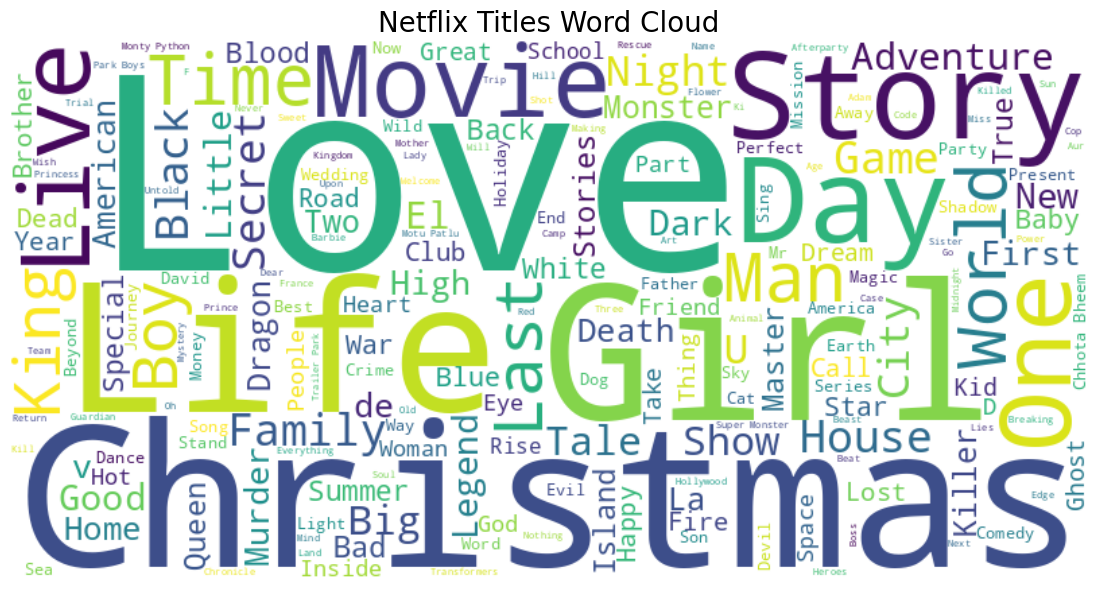

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the Netflix dataset
df = pd.read_csv("titles.csv")

# Combine all titles into one string
text = ' '.join(df['title'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Netflix Titles Word Cloud", fontsize=20)
plt.show()


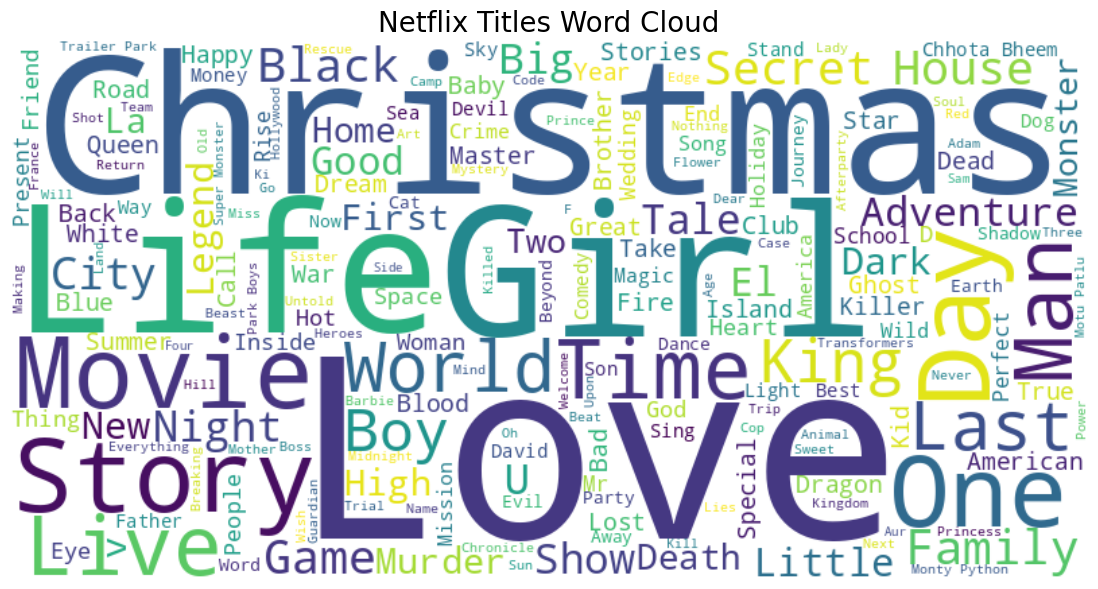

In [ ]:
from wordcloud import STOPWORDS

# Combine all titles
text = ' '.join(df['title'].dropna())

# Add custom stopwords
stopwords = set(STOPWORDS)
stopwords.update(["The", "A", "Of", "And", "Part", "Series", "De"])

wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords=stopwords).generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Netflix Titles Word Cloud", fontsize=20)
plt.show()


In [44]:
#!/usr/bin/env python
# coding: utf-8

import ast, io, base64
import numpy as np
import pandas as pd
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import pycountry

import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State

# ========== Load & preprocess ==========
DF = pd.read_csv("titles.csv")

def to_list(x):
    if pd.isna(x): return []
    if isinstance(x, list): return x
    s = str(x).strip()
    if not s: return []
    if s.startswith('[') and s.endswith(']'):
        try:
            v = ast.literal_eval(s)
            return v if isinstance(v, list) else []
        except Exception:
            return []
    for sep in [',','|',';','/']:
        if sep in s:
            return [t.strip() for t in s.split(sep) if t.strip()]
    return [s]

def clean_genres(lst):
    out = []
    for g in lst:
        if isinstance(g, str):
            g2 = g.strip()
            if g2 and g2.lower() not in {"unknown", "nan", "none"}:
                out.append(g2.title())
    return out

def a2_to_a3(code):
    if not isinstance(code, str): return None
    code = code.upper().strip()
    if code == "XK": return "XKX"
    c = pycountry.countries.get(alpha_2=code)
    return c.alpha_3 if c else None

def a2_to_name(code):
    if not isinstance(code, str): return None
    code = code.upper().strip()
    if code == "XK": return "Kosovo"
    c = pycountry.countries.get(alpha_2=code)
    return c.name if c else code

# list-like columns
DF["genres_list"] = DF["genres"].apply(to_list).apply(clean_genres)
DF["genres_list"] = DF["genres_list"].apply(lambda xs: xs if xs else ["Unknown"])

DF["prod_a2_list"] = DF["production_countries"].apply(to_list)
DF["prod_a3_list"] = DF["prod_a2_list"].apply(lambda xs: [a2_to_a3(x) for x in xs if a2_to_a3(x)])
DF["prod_name_list"] = DF["prod_a2_list"].apply(lambda xs: [a2_to_name(x) for x in xs if a2_to_name(x)])

# dropdown options (initial)
YEARS = sorted(x for x in DF["release_year"].dropna().unique() if str(x).isdigit())
YEAR_OPTIONS = [{"label":"All years","value":"ALL"}] + [{"label":str(y),"value":int(y)} for y in YEARS]

COUNTRY_NAMES = sorted({n for names in DF["prod_name_list"] for n in names})
COUNTRY_OPTIONS = [{"label":"All countries","value":"ALL"}] + [{"label":n,"value":n} for n in COUNTRY_NAMES]

GENRES_ALL = sorted({g for gs in DF["genres_list"] for g in gs})
GENRE_OPTIONS = [{"label":"All genres","value":"ALL"}] + [{"label":g,"value":g} for g in GENRES_ALL]

# ========= helpers to build figures =========
def filter_df(df, year_v, country_v, genre_v):
    out = df
    if year_v != "ALL":
        out = out[out["release_year"] == int(year_v)]
    if country_v != "ALL":
        out = out[out["prod_name_list"].apply(lambda xs: country_v in xs)]
    if genre_v != "ALL":
        out = out[out["genres_list"].apply(lambda xs: genre_v in xs)]
    return out

def make_pie(df, top_n=10, height=430):
    if df.empty:
        fig = px.pie(values=[1], names=["No data"], title="Top Genres")
        fig.update_layout(height=height, margin=dict(l=40,r=20,t=40,b=40))
        return fig
    joined = df["genres_list"].apply(lambda lst: "|".join(sorted(set(lst))))
    dummies = joined.str.get_dummies(sep="|").astype("int64")
    counts = dummies.sum().sort_values(ascending=False)
    top = counts.head(top_n).copy()
    other = counts.iloc[top_n:].sum()
    if other > 0:
        top.loc["Other"] = other
    fig = px.pie(values=top.values, names=top.index,
                 title=f"Top {top_n} Genres (with 'Other')", hole=0.3)
    fig.update_traces(textinfo="percent+label")
    fig.update_layout(height=height, margin=dict(l=40,r=20,t=40,b=40))
    return fig

def make_wordcloud_src(df, height=430):
    text = " ".join(df["title"].dropna().astype(str).tolist()) or "No Data"
    stop = set(STOPWORDS)
    stop.update({"The","A","Of","And","Part","Series","De"})
    wc = WordCloud(width=1000, height=height, background_color="white", stopwords=stop).generate(text)
    buf = io.BytesIO()
    wc.to_image().save(buf, format="PNG")
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("utf-8")

def make_map(df, height=430):
    exp = df.explode("prod_a3_list").dropna(subset=["prod_a3_list"])
    if exp.empty:
        fig = px.choropleth(pd.DataFrame({"iso":[], "titles":[]}), locations="iso", color="titles",
                            title="Titles by Production Country")
        fig.update_layout(height=height, margin=dict(l=0,r=0,t=50,b=0))
        return fig
    by = (exp.groupby("prod_a3_list", as_index=False)
              .size().rename(columns={"prod_a3_list":"iso_a3","size":"titles"}))
    zmax = by["titles"].max()
    fig = px.choropleth(by, locations="iso_a3", color="titles",
                        color_continuous_scale="YlOrRd", range_color=(0, zmax),
                        projection="natural earth",
                        title="Titles by Production Country (current filters)")
    fig.update_layout(height=height, margin=dict(l=0,r=0,t=50,b=0))
    return fig

def make_sunburst(df, K=3, TOP_N=8, height=430):
    if df.empty:
        fig = px.sunburst(pd.DataFrame({"type":[], "age_certification":[], "genre":[], "titles":[]}),
                          path=["type","age_certification","genre"], values="titles",
                          title="Type → Rating → Top Genres")
        fig.update_layout(height=height, margin=dict(l=0,r=0,t=50,b=0))
        return fig
    g = df.explode("genres_list").rename(columns={"genres_list":"genre"})
    g["genre"] = g["genre"].fillna("Unknown")
    g["type"] = g["type"].fillna("Unknown")
    g["age_certification"] = g["age_certification"].fillna("Unknown")
    top_overall = g["genre"].value_counts().head(TOP_N).index
    g["genre_group"] = g["genre"].where(g["genre"].isin(top_overall), "Other")
    agg = (g.groupby(["type","age_certification","genre_group"], as_index=False)
             .size().rename(columns={"size":"titles"}))
    agg["rank_in_parent"] = (agg.groupby(["type","age_certification"])["titles"]
                                .rank(method="first", ascending=False))
    pruned = (agg.assign(genre_pruned=np.where(agg["rank_in_parent"]<=K,
                                               agg["genre_group"], "Other"))
                 .groupby(["type","age_certification","genre_pruned"], as_index=False)["titles"].sum())
    fig = px.sunburst(pruned, path=["type","age_certification","genre_pruned"], values="titles",
                      color="type", color_discrete_map={"MOVIE":"#636EFA","SHOW":"#EF553B"},
                      title=f"Type → Rating → Top-{K} Genres (others grouped)")
    fig.update_traces(textinfo="label+percent parent", maxdepth=2)
    fig.update_layout(height=height, margin=dict(l=0,r=0,t=50,b=0))
    return fig

def country_options_from(df_subset, show_counts=True):
    exp = df_subset.explode("prod_name_list").dropna(subset=["prod_name_list"])
    if exp.empty:
        return [{"label": "All countries", "value": "ALL"}]
    vc = exp["prod_name_list"].value_counts().sort_index()
    opts = [{"label": f"{name} ({int(cnt)})" if show_counts else name, "value": name}
            for name, cnt in vc.items()]
    return [{"label": "All countries", "value": "ALL"}] + opts

# ========== Dash app (CLASS TEMPLATE STYLE) ==========
app = dash.Dash(__name__)
app.title = "Netflix Explorer"

# Layout: title, three dropdowns, single output-container
app.layout = html.Div([
    html.H2("Netflix Catalogue Explorer",
            style={'textAlign': 'center', 'margin':'8px 0 16px'}),

    html.Div([
        html.Div([
            html.Label("Year"),
            dcc.Dropdown(id='year-dd', options=YEAR_OPTIONS, value='ALL', clearable=False,
                         style={'minWidth':'220px'})
        ]),
        html.Div([
            html.Label("Country"),
            dcc.Dropdown(id='country-dd', options=COUNTRY_OPTIONS, value='ALL', clearable=False,
                         style={'minWidth':'260px'})
        ]),
        html.Div([
            html.Label("Genre"),
            dcc.Dropdown(id='genre-dd', options=GENRE_OPTIONS, value='ALL', clearable=False,
                         style={'minWidth':'260px'})
        ]),
    ], style={'display':'flex','gap':'16px','flexWrap':'wrap','marginBottom':'10px'}),

    html.Div(id='output-container')  # charts go here (2 rows of 2)
], style={'maxWidth':'1300px','margin':'0 auto','padding':'12px'})

# --- Callback 1: update Country options to only those present under Year+Genre ---
@app.callback(
    Output("country-dd", "options"),
    Output("country-dd", "value"),
    Input("year-dd", "value"),
    Input("genre-dd", "value"),
    State("country-dd", "value"),
)
def refresh_country_options(year_v, genre_v, current_country):
    dff = filter_df(DF, year_v, "ALL", genre_v)
    new_options = country_options_from(dff, show_counts=True)
    valid = {opt["value"] for opt in new_options}
    new_value = current_country if current_country in valid else "ALL"
    return new_options, new_value

# --- Callback 2: build 2×2 charts like the class template (single Output -> children) ---
@app.callback(
    Output('output-container', 'children'),
    [Input('year-dd','value'),
     Input('country-dd','value'),
     Input('genre-dd','value')]
)
def render_two_by_two(year_v, country_v, genre_v):
    dff = filter_df(DF, year_v, country_v, genre_v)

    CH = 430  # consistent height
    # 1) Pie (genres)
    fig_pie = make_pie(dff, top_n=10, height=CH)
    pie_div  = dcc.Graph(figure=fig_pie, style={'height': f'{CH}px'})

    # 2) Word cloud (titles)
    wc_src = make_wordcloud_src(dff, height=CH)
    wc_div = html.Div([
        html.H4("Word Cloud (Titles)"),
        html.Img(src=wc_src, style={'width':'100%','height':f'{CH-40}px',
                                    'objectFit':'contain','border':'1px solid #ddd'})
    ])

    # 3) Choropleth (production countries)
    fig_map = make_map(dff, height=CH)
    map_div = dcc.Graph(figure=fig_map, style={'height': f'{CH}px'})

    # 4) Sunburst (Type → Rating → Top-K Genres)
    fig_sun = make_sunburst(dff, K=3, TOP_N=8, height=CH)
    sun_div = dcc.Graph(figure=fig_sun, style={'height': f'{CH}px'})

    # helpers: two charts per row (flex)
    def cell(child):
        return html.Div(child, style={'flex':'1 1 0%','minWidth':0})
    def row(left, right):
        return html.Div([cell(left), cell(right)],
                        style={'display':'flex','gap':'16px','marginBottom':'16px'})

    return [
        row(pie_div, wc_div),
        row(map_div, sun_div),
    ]

if __name__ == "__main__":
    app.run(debug=True, host="127.0.0.1", port=8050)


<IPython.core.display.Javascript object>